In [1]:
import torch
import torchvision
import time


In [2]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

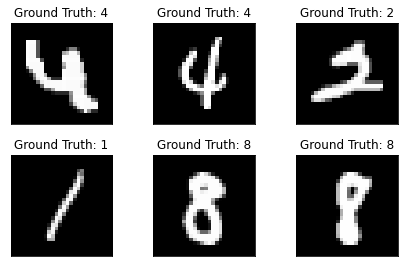

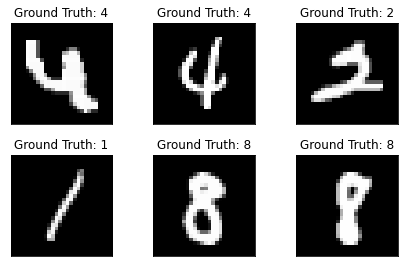

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
import torch.nn.functional as F
cuda0 = torch.device('cuda:0')
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return F.log_softmax(y_pred)

In [8]:
import torch.optim as optim
import torch.nn as nn
import os
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 28*28, 100, 10

# Create random Tensors to hold inputs and outputs

# Construct our model by instantiating the class defined above
def trainCuda(epoch, modelCuda, optimizerCuda, train_losses, train_counter):
  modelCuda.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizerCuda.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in)).cuda()
    target = target.cuda()
    output = modelCuda(data).cuda()
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizerCuda.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(modelCuda.state_dict(), 'model.pth')
      torch.save(optimizerCuda.state_dict(), 'optimizer.pth')
def testCuda(modelCuda, test_losses):
  modelCuda.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in)).cuda()
      target = target.cuda()
      data = data.cuda()
      output = modelCuda(data).cuda()
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [9]:

def train(epoch, model, optimizer, train_losses, train_counter):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in))
    target = target
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

def test(model, test_losses):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in))
      target = target
      data = data
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [10]:
def evalNormal(sizeH):
    if os.path.exists("model.pth"):
        os.remove("model.pth")
    if os.path.exists("optimizer.pth"):
        os.remove("optimizer.pth")
    model = TwoLayerNet(D_in, sizeH, D_out)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    start = time.time()
    test(model, test_losses)
    for epoch in range(1, n_epochs + 1):
        train(epoch, model, optimizer, train_losses, train_counter)
        test(model, test_losses)
    end = time.time()
    print("Normal time: " + str(end - start))
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

025354
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.005849
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.007081
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.009849
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.018957
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.011076
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.008106
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.010574
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.007761
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.018313
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.021069
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.006558
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.009427

Test set: Avg. loss: 0.0662, Accuracy: 9803/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.017595
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.012694
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.007941
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.010216
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.004580
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.007027
Train Epoch: 47 [3840/60000 (6%)]

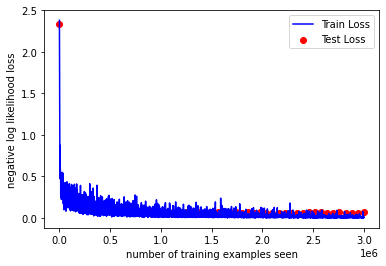

In [41]:
evalNormal(100)

011171
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.009429
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.004326
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.034049
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.011624
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.009486
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.012008
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.006505
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.025397
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.091150
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.011744
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.012110
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.036903

Test set: Avg. loss: 0.0888, Accuracy: 9756/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.010019
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.013443
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.013210
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.026329
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.007711
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.012880
Train Epoch: 47 [3840/60000 (6%)]

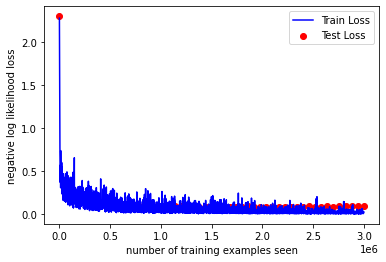

In [42]:
evalNormal(50)

003637
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.005608
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.003512
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.001512
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.011893
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.002941
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.005854
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.016658
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.011079
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.006337
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.010156
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.004574
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.009833

Test set: Avg. loss: 0.0572, Accuracy: 9817/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.002223
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.003227
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.001913
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.009345
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.003532
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.005049
Train Epoch: 47 [3840/60000 (6%)]

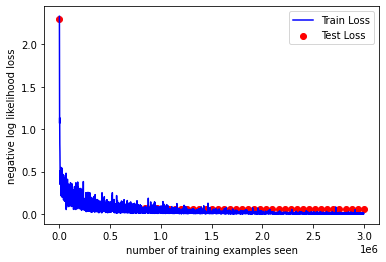

In [11]:
evalNormal(1000)

In [12]:
def evalNormalCuda(sizeH):
    if os.path.exists("model.pth"):
        os.remove("model.pth")
    if os.path.exists("optimizer.pth"):
        os.remove("optimizer.pth")
    model = TwoLayerNet(D_in, sizeH, D_out).cuda()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    start = time.time()
    testCuda(model, test_losses)
    for epoch in range(1, n_epochs + 1):
        trainCuda(epoch, model, optimizer, train_losses, train_counter)
        testCuda(model, test_losses)
    end = time.time()
    print("Normal time cuda: " + str(end - start))
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

7
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.021624
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.006638
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.010818
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.010056
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.023135
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.005717
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.010890
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.029979
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.031904
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.025861
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.010397
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.015495

Test set: Avg. loss: 0.0774, Accuracy: 9765/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.025462
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.043317
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.013079
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.002419
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.094907
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.035940
Train Epoch: 47 [3840/60000 (6%)]	Loss

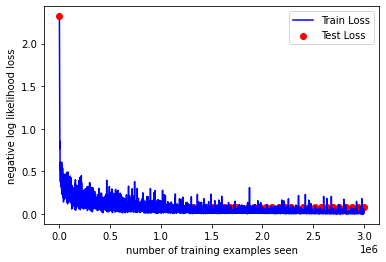

In [13]:
evalNormalCuda(50)

8
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.010089
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.011981
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.019008
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.006999
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.021342
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.003936
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.009523
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.017019
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.015478
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.008920
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.006072
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.004599

Test set: Avg. loss: 0.0678, Accuracy: 9791/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.005586
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.026299
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.002201
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.007645
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.008936
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.013139
Train Epoch: 47 [3840/60000 (6%)]	Loss

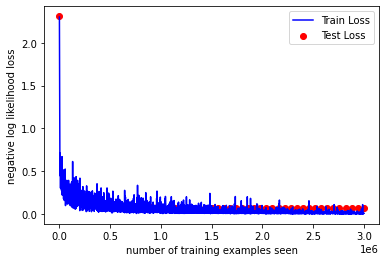

In [14]:
evalNormalCuda(100)

3
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.015663
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.008302
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.001973
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.003659
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.010669
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.005079
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.003168
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.007313
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.007359
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.003979
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.002928
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.009588

Test set: Avg. loss: 0.0572, Accuracy: 9827/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.003609
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.006323
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.004752
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.002163
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.007562
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.005912
Train Epoch: 47 [3840/60000 (6%)]	Loss

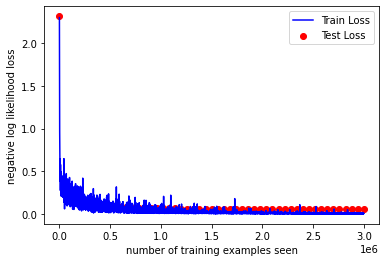

In [15]:
evalNormalCuda(1000)

In [16]:
import torch.nn.functional as F
cuda0 = torch.device('cuda:0')
class TwoLayerNetCE(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNetCE, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

In [17]:

def trainCE(epoch, model, optimizer, train_losses, train_counter):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in))
    target = target
    output = model(data)
    crossEntropy = nn.CrossEntropyLoss()
    loss = crossEntropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

def testCE(model, test_losses):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in))
      target = target
      data = data
      output = model(data)
      crossEntropy = nn.CrossEntropyLoss(size_average=False)
      test_loss += crossEntropy(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [18]:
def evalNormalCE(sizeH):
    if os.path.exists("model.pth"):
        os.remove("model.pth")
    if os.path.exists("optimizer.pth"):
        os.remove("optimizer.pth")
    model = TwoLayerNetCE(D_in, sizeH, D_out)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    start = time.time()
    testCE(model, test_losses)
    for epoch in range(1, n_epochs + 1):
        trainCE(epoch, model, optimizer, train_losses, train_counter)
        testCE(model, test_losses)
    end = time.time()
    print("Normal time: " + str(end - start))
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('Cross entropy loss')
    fig

003737
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.022798
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.016018
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.005251
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.016685
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.005535
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.020244
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.044408
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.017158
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.032191
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.010935
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.015142
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.007620

Test set: Avg. loss: 0.0879, Accuracy: 9741/10000 (97%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.013722
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.008517
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.004934
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.008721
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.013899
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.031385
Train Epoch: 47 [3840/60000 (6%)]

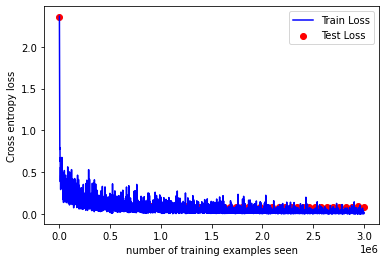

In [19]:
evalNormalCE(50)

005800
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.004924
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.018603
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.002845
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.015253
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.023340
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.050904
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.011907
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.012992
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.006164
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.004599
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.010393
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.004590

Test set: Avg. loss: 0.0710, Accuracy: 9803/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.005727
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.012674
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.011156
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.003866
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.005740
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.007335
Train Epoch: 47 [3840/60000 (6%)]

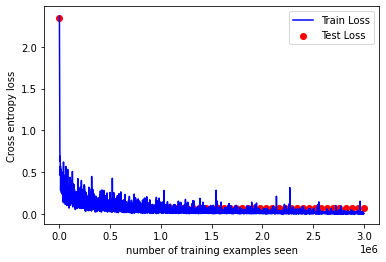

In [20]:
evalNormalCE(100)

006961
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.003992
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.007261
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.005982
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.003554
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.006542
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.005216
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.016867
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.005614
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.005749
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.001391
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.002267
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.004328

Test set: Avg. loss: 0.0582, Accuracy: 9827/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.009323
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.004522
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.002098
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.006752
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.007102
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.013426
Train Epoch: 47 [3840/60000 (6%)]

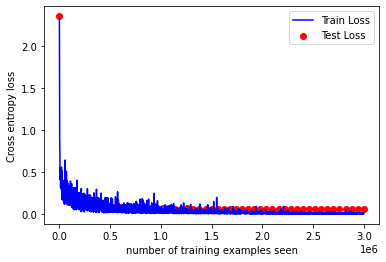

In [21]:
evalNormalCE(1000)

In [22]:
def trainCudaCE(epoch, modelCuda, optimizerCuda, train_losses, train_counter):
  modelCuda.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizerCuda.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in)).cuda()
    target = target.cuda()
    output = modelCuda(data).cuda()
    crossEntropy = nn.CrossEntropyLoss()
    loss = crossEntropy(output, target)
    loss.backward()
    optimizerCuda.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(modelCuda.state_dict(), 'model.pth')
      torch.save(optimizerCuda.state_dict(), 'optimizer.pth')
def testCudaCE(modelCuda, test_losses):
  modelCuda.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in)).cuda()
      target = target.cuda()
      data = data.cuda()
      output = modelCuda(data).cuda()
      crossEntropy = nn.CrossEntropyLoss(size_average=False)
      test_loss += crossEntropy(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [23]:
def evalCudaCE(sizeH):
    if os.path.exists("model.pth"):
        os.remove("model.pth")
    if os.path.exists("optimizer.pth"):
        os.remove("optimizer.pth")
    model = TwoLayerNetCE(D_in, sizeH, D_out).cuda()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    start = time.time()
    testCudaCE(model, test_losses)
    for epoch in range(1, n_epochs + 1):
        trainCudaCE(epoch, model, optimizer, train_losses, train_counter)
        testCudaCE(model, test_losses)
    end = time.time()
    print("Normal time cuda: " + str(end - start))
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('cross entropy loss')
    fig

0
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.048676
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.085340
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.008057
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.014600
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.015602
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.048922
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.010232
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.022019
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.011576
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.009014
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.003043
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.015217

Test set: Avg. loss: 0.0850, Accuracy: 9757/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.023501
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.019606
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.014755
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.017111
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.005691
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.020781
Train Epoch: 47 [3840/60000 (6%)]	Loss

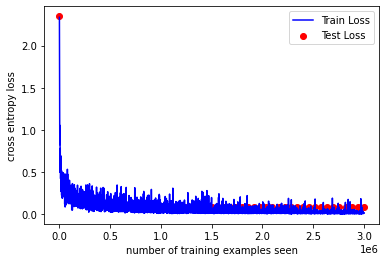

In [24]:
evalCudaCE(50)

8
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.009098
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.012682
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.003669
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.021711
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.023129
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.009747
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.002923
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.009225
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.014671
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.011391
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.005886
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.014787

Test set: Avg. loss: 0.0702, Accuracy: 9786/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.018604
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.004451
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.017467
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.023880
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.007497
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.011060
Train Epoch: 47 [3840/60000 (6%)]	Loss

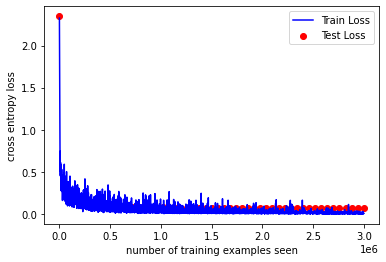

In [25]:
evalCudaCE(100)

9
Train Epoch: 46 [52480/60000 (87%)]	Loss: 0.004603
Train Epoch: 46 [53120/60000 (88%)]	Loss: 0.008413
Train Epoch: 46 [53760/60000 (90%)]	Loss: 0.005554
Train Epoch: 46 [54400/60000 (91%)]	Loss: 0.007369
Train Epoch: 46 [55040/60000 (92%)]	Loss: 0.003641
Train Epoch: 46 [55680/60000 (93%)]	Loss: 0.004513
Train Epoch: 46 [56320/60000 (94%)]	Loss: 0.004511
Train Epoch: 46 [56960/60000 (95%)]	Loss: 0.007245
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.001502
Train Epoch: 46 [58240/60000 (97%)]	Loss: 0.001482
Train Epoch: 46 [58880/60000 (98%)]	Loss: 0.004567
Train Epoch: 46 [59520/60000 (99%)]	Loss: 0.004031

Test set: Avg. loss: 0.0558, Accuracy: 9828/10000 (98%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.003454
Train Epoch: 47 [640/60000 (1%)]	Loss: 0.006617
Train Epoch: 47 [1280/60000 (2%)]	Loss: 0.008276
Train Epoch: 47 [1920/60000 (3%)]	Loss: 0.006333
Train Epoch: 47 [2560/60000 (4%)]	Loss: 0.007752
Train Epoch: 47 [3200/60000 (5%)]	Loss: 0.001674
Train Epoch: 47 [3840/60000 (6%)]	Loss

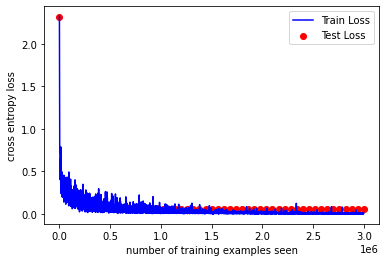

In [26]:
evalCudaCE(1000)